In [1]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Open and read the text file
with open('ex5data.txt', 'r') as file:
    lines = file.readlines()

# Split each line by commas and create a list of lists
split_data = [line.strip().split(',') for line in lines]

# Convert the split data into a list of tuples with numeric values
numeric_data = [(float(row[0]), float(row[1]), float(row[2])) for row in split_data]

# Specify column names
column_names = ['x1', 'x2', 'y']

# Create a Polars DataFrame with specified schema
data = pl.DataFrame(numeric_data, schema=[(col, pl.Float64) for col in column_names], orient="row")

columns = data.columns
n = len(columns)-1
m  = len(data)
x = data.select(columns[:n])
y = data.select(columns[-1])

Text(0.5, 1.0, 'Scatter plot of x1 vs x2 colored by y')

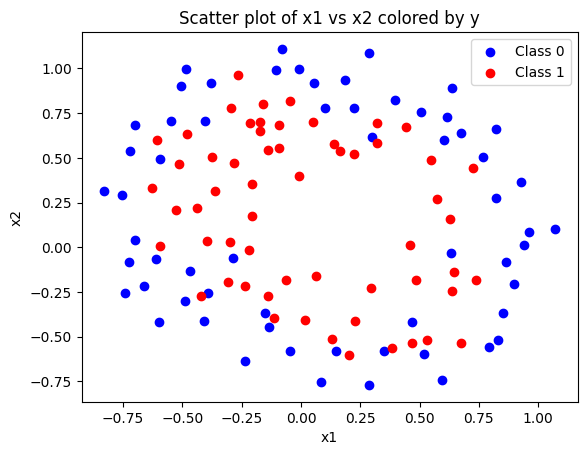

In [3]:
x1 = data['x1'].to_list()
x2 = data['x2'].to_list()
y_list = data['y'].to_list()

plt.figure()
plt.scatter([x1[i] for i in range(len(y_list)) if y_list[i] == 0], [x2[i] for i in range(len(y_list)) if y_list[i] == 0], color='blue', label='Class 0')
plt.scatter([x1[i] for i in range(len(y_list)) if y_list[i] == 1], [x2[i] for i in range(len(y_list)) if y_list[i] == 1], color='red', label='Class 1')

plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.title('Scatter plot of x1 vs x2 colored by y')

In [7]:
degrees = 6
def mapfeature(degrees, x):
    results = []
    for d in range(1, degrees+1):
        for i in range(d, -1, -1):
            term = x['x1'] ** i * x['x2'] ** (d - i)
            results.append(term)

    # Exclude the first two columns from the results
    results = results[2:]

    # Convert the accumulated results to Polars Series
    for idx in range(len(results)):
        x = x.with_columns(pl.Series(f'res{idx}', results[idx]))

    return x

# Display the updated DataFrame
x_new = mapfeature(degrees=degrees, x=x)
columns = x_new.columns
n = len(columns)

In [ ]:
x_new

In [8]:
standardized_x = x_new.with_columns(pl.lit(1).alias("constant"))
standardized_x = standardized_x.select(["constant"] + [col for col in standardized_x.columns if col != "constant"])
x_mat = standardized_x.to_numpy().reshape(-1, n+1).T
y_mat = y.to_numpy().reshape(-1, 1)

[[-30.41595306]]
[[-28.30161369]]
[[-26.41975273]]
[[-24.7418321]]
[[-23.24278511]]
[[-21.90069187]]
[[-20.69647364]]
[[-19.61360609]]


/tmp/ipykernel_34474/1220595988.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  z_mat[i, j] = np.dot(standardized_z.to_numpy().reshape(-1, n+1), theta)


[[-18.63785149]]
[[-17.75700982]]
[[-16.96068882]]
[[-16.2400929]]
[[-15.58783106]]
[[-14.99774365]]
[[-14.4647481]]
[[-13.98470357]]
[[-13.55429447]]
[[-13.17093298]]
[[-12.83268045]]
[[-12.53818767]]
[[-12.2866542]]
[[-12.07780644]]
[[-11.9118948]]
[[-11.78970965]]
[[-11.71261627]]
[[-11.68260872]]
[[-11.70238257]]
[[-11.77542662]]
[[-11.9061335]]
[[-12.09992925]]
[[-12.36342168]]
[[-12.70456787]]
[[-13.13286036]]
[[-13.65953244]]
[[-14.29778227]]
[[-15.06301592]]
[[-15.97310942]]
[[-17.04868957]]
[[-18.31343387]]
[[-19.79438917]]
[[-21.52230942]]
[[-23.53201221]]
[[-25.86275431]]
[[-28.5586261]]
[[-31.66896488]]
[[-35.24878724]]
[[-39.35924015]]
[[-44.06807115]]
[[-49.45011738]]
[[-55.5878135]]
[[-27.78992471]]
[[-25.71356093]]
[[-23.86564833]]
[[-22.21793601]]
[[-20.74561619]]
[[-19.4270007]]
[[-18.24321636]]
[[-17.17791933]]
[[-16.21702832]]
[[-15.34847681]]
[[-14.56198406]]
[[-13.84884519]]
[[-13.20174006]]
[[-12.61456115]]
[[-12.08226031]]
[[-11.60071446]]
[[-11.16661022]]
[[-10

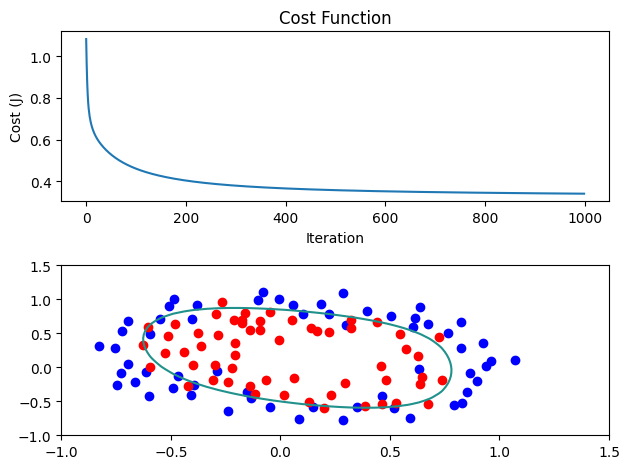

In [11]:
theta = np.random.rand(n+1, 1)
H = 1 / (1 + np.exp(-np.dot(theta.T, x_mat))).T
alpha = 1
loop = 1000
J_values = np.zeros((loop, 1))
for i in range(loop):
    theta = theta - (alpha/m)*np.dot(x_mat, (H-y_mat))
    H = 1 / (1 + np.exp(-np.dot(theta.T, x_mat))).T
    J_values[i] = 1/(m)*(-np.dot(y_mat.T, np.log(H))-np.dot(1-y_mat.T, np.log(1-H)))

standardized_data = standardized_x.with_columns(y)

u = np.linspace(-1, 1.5, 50)
v = np.linspace(-1, 1.5, 50)
z_mat = np.zeros((len(u), len(v)))
for i in range(len(u)):
    for j in range(len(v)):
        z = mapfeature(degrees=degrees, x=pl.DataFrame({'x1': [u[i]], 'x2': [v[j]]}))
        standardized_z = z.with_columns(pl.lit(1).alias("constant"))
        standardized_z = standardized_z.select(["constant"] + [col for col in standardized_z.columns if col != "constant"])
        print(np.dot(standardized_z.to_numpy().reshape(-1, n+1), theta))
        z_mat[i, j] = np.dot(standardized_z.to_numpy().reshape(-1, n+1), theta)
z_mat = z_mat.T

# Create a figure and a set of subplots
fig, axs = plt.subplots(2)

# Plot the cost function on the first subplot
axs[0].plot(J_values)
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Cost (J)')
axs[0].set_title('Cost Function')

# Plot the cost function on the first subplot
axs[1].scatter([x1[i] for i in range(len(y_list)) if y_list[i] == 0], [x2[i] for i in range(len(y_list)) if y_list[i] == 0], color='blue', label='Class 0')
axs[1].scatter([x1[i] for i in range(len(y_list)) if y_list[i] == 1], [x2[i] for i in range(len(y_list)) if y_list[i] == 1], color='red', label='Class 1')
axs[1].contour(u, v, z_mat, 0)


# Layout so plots do not overlap
fig.tight_layout()